# Prostate Lesion MONAI Application Package (MAP)

This notebook takes MONAI application code and associated models for MRI prostate lesion segmentation and creates a deployable container called a MONAI Application Package (MAP). We can use this container for standalone inference or integrate it into more sophisticated medical imaging workflow tools like [MONAI Deploy Express](https://github.com/Project-MONAI/monai-deploy/tree/main/deploy/monai-deploy-express). Note: MONAI Deploy Express is NOT recommended for production environments.

In [ ]:
# Install MONAI Deploy App SDK
!pip install monai-deploy-app-sdk==0.5.1

The monai-deploy CLI `package` command will pull a base image (in this case, nvcr.io/nvidia/pytorch:22.08-py3 from [NGC](https://ngc.nvidia.com)) and install all the necessary software to create a MAP. 

This workflow is verified for version 0.5.1 of MONAI Deploy App SDK. Version 0.6.0+ integrates components from [NVIDIA Holoscan SDK](https://github.com/nvidia-holoscan/holoscan-sdk) and is not currently compatible.

In [ ]:
# Package the MAP
!monai-deploy package -l DEBUG -b nvcr.io/nvidia/pytorch:22.08-py3 ./prostate_mri_lesion_seg_app --tag lesion_seg_workflow_app:v1.0 -m prostate_mri_lesion_seg_app/models/

# Visualize Input

Before running inference, let's visualize the multi-parametric MRI input data.

You can download a sample image from ProstateX [here](https://drive.google.com/drive/folders/17oOgs1jIgJUxtkBRLATUdNrLSNQCLpCn?usp=sharing) and place it in a `test-data` folder.

In [3]:
# Set to the path of the directory containing DICOM files
dcm_dir = "./test-data/ProstateX-0004/"

In [4]:
import pydicom
import matplotlib.pyplot as plt
import glob
import numpy as np

# Function to load and visualize a DICOM MRI image
def load_and_visualize_dicom_image(dir):
    files = []

    for filename in glob.glob(dir + '/*.dcm'):
        files.append(pydicom.dcmread(filename))

    slices = sorted(files, key=lambda s: s.SliceLocation)

    # Pixel aspects, assuming all slices are the same
    ps = slices[0].PixelSpacing
    ss = slices[0].SliceThickness
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]

    # Create 3D array
    img_shape = list(slices[0].pixel_array.shape)
    img_shape.append(len(slices))
    img3d = np.zeros(img_shape)

    # Fill 3D array with the images from the files
    for i, s in enumerate(slices):
        img2d = s.pixel_array
        img3d[:, :, i] = img2d

    # Plot same three slices with larger size
    plt.figure(figsize=(20, 8))

    a1 = plt.subplot(1, 3, 1)
    plt.imshow(img3d[:, :, img_shape[2]//2], cmap="gray")
    a1.set_aspect(ax_aspect)

    a2 = plt.subplot(1, 3, 2)
    plt.imshow(img3d[:, img_shape[1]//2, :], cmap="gray")
    a2.set_aspect(sag_aspect)

    a3 = plt.subplot(1, 3, 3)
    plt.imshow(img3d[img_shape[0]//2, :, :].T, cmap="gray")
    a3.set_aspect(cor_aspect)

    plt.show()

Note that some of the default ProstateX folder names were changed to remove spacing. This was already adjusted in the provided test data folder.

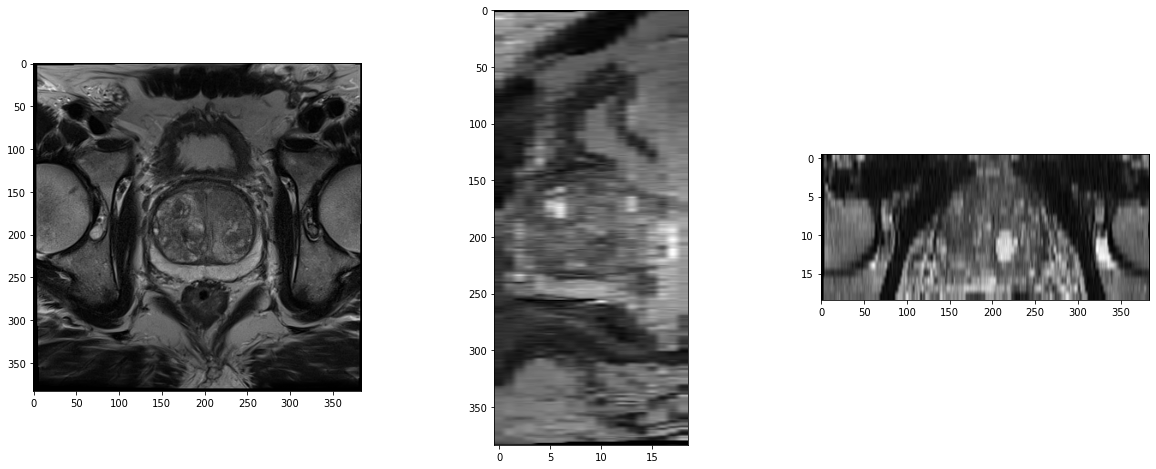

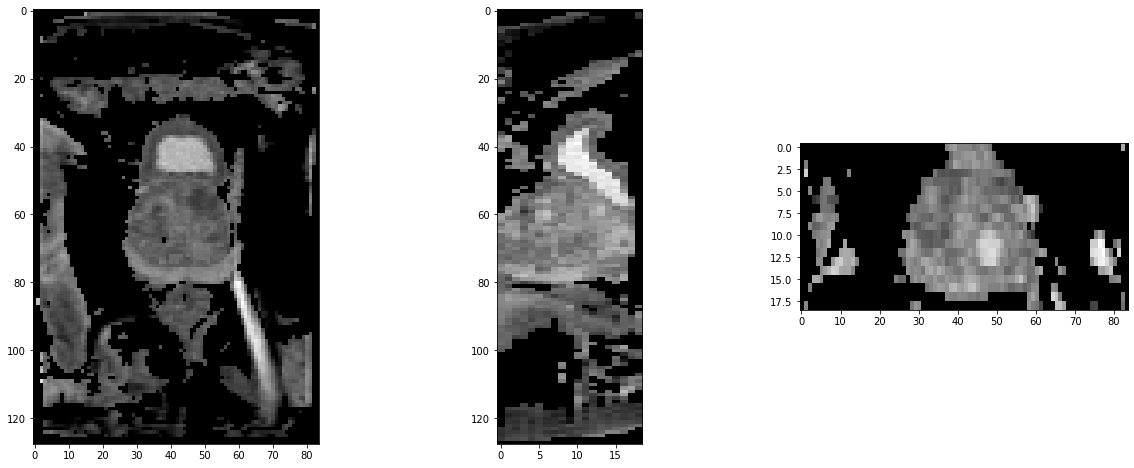

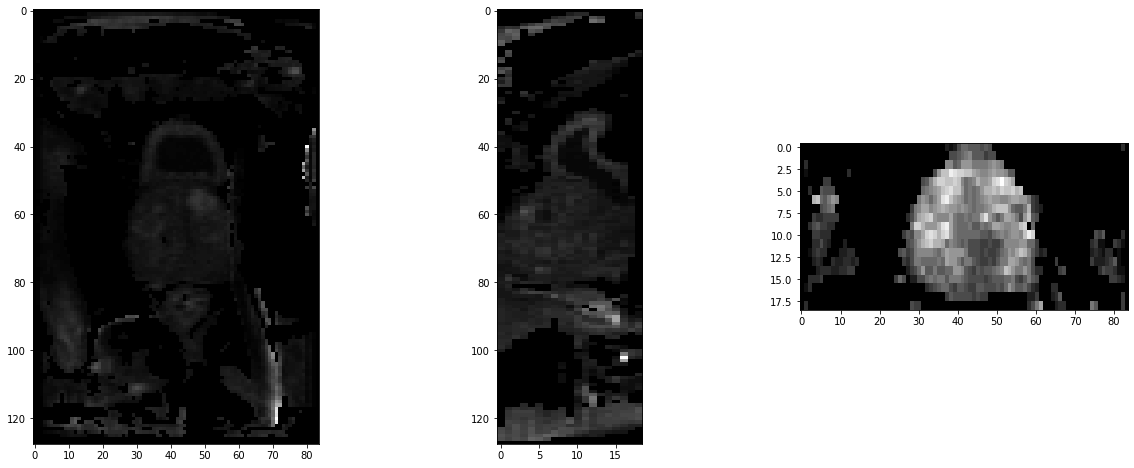

In [5]:
load_and_visualize_dicom_image(dcm_dir + "10-18-2011-MR-prostaat-kanker-detectie-WDSmc-MCAPRODETW-45493/5.000000-t2tsetra-75680") # T2
load_and_visualize_dicom_image(dcm_dir + "10-18-2011-MR-prostaat-kanker-detectie-WDSmc-MCAPRODETW-45493/7.000000-ep2ddifftraDYNDISTMIXADC-91158") # ADC
load_and_visualize_dicom_image(dcm_dir + "10-18-2011-MR-prostaat-kanker-detectie-WDSmc-MCAPRODETW-45493/8.000000-ep2ddifftraDYNDISTMIXCALCBVAL-20138") # HighB

# Run Inference with the MAP

The monai-deploy `run` command executes the container and mounts local folders as input/output.

In [ ]:
!monai-deploy run lesion_seg_workflow_app:v1.0 {dcm_dir} output

# Visualize Output

In [7]:
import nibabel as nib

output_dir = "./output"
slice_adjustment = -3 # Adjust slice index for better lesion visualization

# Load the input data
t2 = nib.load(output_dir + "/t2/t2.nii.gz").get_fdata()
adc = nib.load(output_dir + "/adc/adc.nii.gz").get_fdata()
highb = nib.load(output_dir + "/highb/highb.nii.gz").get_fdata()

# Load the output data
organ_seg = nib.load(output_dir + "/organ/organ.nii.gz").get_fdata()
lesion_seg = nib.load(output_dir + "/lesion/lesion_mask.nii.gz").get_fdata()
lesion_prob = nib.load(output_dir + "/lesion/merged_lesion_prob.nii.gz").get_fdata()

# Rearrange lesion data
lesion_seg = np.flip(lesion_seg, axis=0)
lesion_seg = np.flip(lesion_seg, axis=1)
lesion_prob = np.flip(lesion_prob, axis=0)
lesion_prob = np.flip(lesion_prob, axis=1)

First we'll visualize the prostate organ segmentation.

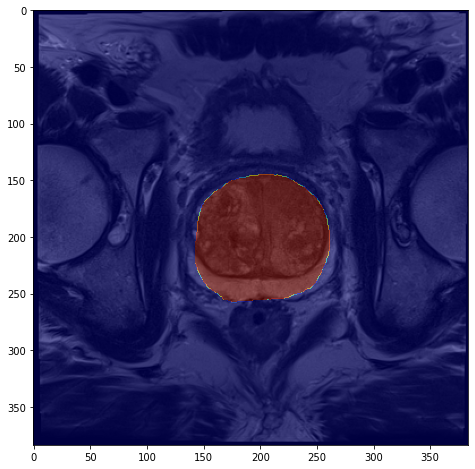

In [8]:
# View organ segmentation
plt.figure(figsize=(20, 8))
slice_adjustment = -3

plt.imshow(t2[:, :, t2.shape[2]//2].T, cmap="gray")
plt.imshow(organ_seg[:, :, t2.shape[2]//2+slice_adjustment].T, cmap="jet", alpha=0.5)

Next we'll overlay the lesion segmentation on the T2 image and plot the lesion probability map separately.

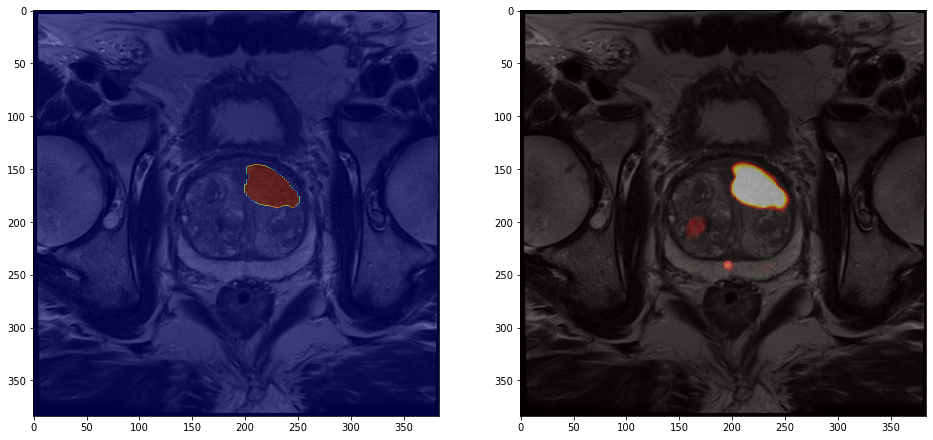

In [9]:
# Plot all modalities including T2 image with overlayed lesion probability map
slice_adjustment = -3

plt.figure(figsize=(16, 16))
lesion_viz = plt.subplot(1, 2, 1)
plt.imshow(t2[:, :, t2.shape[2]//2].T, cmap="gray")
plt.imshow(lesion_seg[:, :, t2.shape[2]//2+slice_adjustment].T, cmap="jet", alpha=0.5)

prob_viz = plt.subplot(1, 2, 2)
plt.imshow(t2[:, :, t2.shape[2]//2].T, cmap="gray")
plt.imshow(lesion_prob[:, :, t2.shape[2]//2+slice_adjustment].T, cmap="hot", alpha=0.5)